In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')
plt.style.use('fast')



MAPE Function


In [11]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
df = pd.read_csv("PJME_hourly.csv", index_col=[0],
                  parse_dates=[0])
df.head()


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


Plot the time series:

<AxesSubplot:>

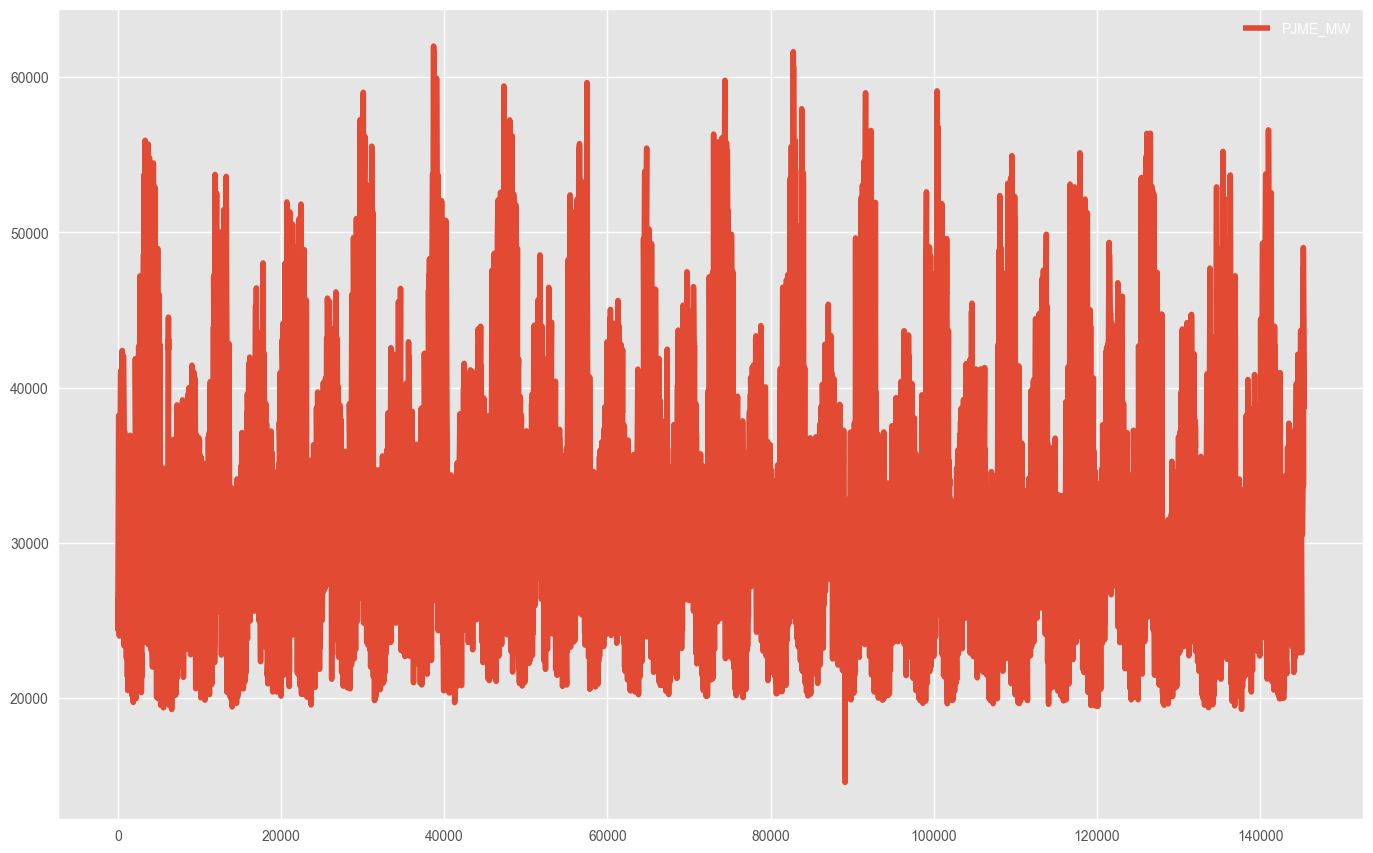

In [53]:
plt.rcParams['figure.figsize'] = (15, 10)
df.plot(kind='line', y='PJME_MW')

Train/test split

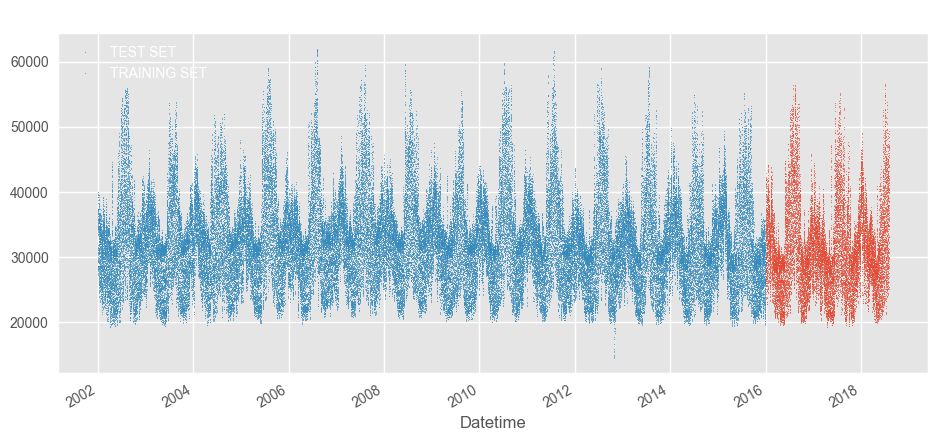

In [30]:
split_point = '1-Jan-2016'
df_train = df.loc[df.index < split_point].copy()
df_test = df.loc[df.index >= split_point].copy()


df_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(df_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Energy Consumption (MW)', style='.', ms=1)
plt.show()

Adjust format of dataset according to Prophet package

In [15]:
train_prophet = df_train.reset_index() \
    .rename(columns={'Datetime':'ds', 'PJME_MW':'y'})

test_prophet = df_test.reset_index() \
    .rename(columns={'Datetime':'ds', 'PJME_MW':'y'})

Instance the model and train

In [17]:
model = Prophet()
model.fit(train_prophet)

11:10:26 - cmdstanpy - INFO - Chain [1] start processing
11:12:38 - cmdstanpy - INFO - Chain [1] done processing


Test the model

In [63]:
prophet_forecast = model.predict(test_prophet)
prophet_forecast.head()
prophet_forecast.loc[:,['ds','yhat_lower','yhat_upper','yhat','trend']]

,ds,yhat_lower,yhat_upper,yhat,trend
0,2016-01-01 00:00:00,25439.369302,34660.018785,30003.037051,31217.898672
1,2016-01-01 01:00:00,23593.035173,32583.823439,27986.257615,31217.867138
2,2016-01-01 02:00:00,22068.344200,31004.005496,26485.508878,31217.835604
3,2016-01-01 03:00:00,20791.540321,30289.531966,25613.179301,31217.804070
4,2016-01-01 04:00:00,20752.376604,29847.287888,25468.367381,31217.772536
...,...,...,...,...,...
22675,2018-08-02 20:00:00,22108.720303,59477.158850,41691.940934,30502.835532
22676,2018-08-02 21:00:00,20684.628889,59564.980654,40912.203071,30502.803998
22677,2018-08-02 22:00:00,19242.176365,57379.452898,39282.961743,30502.772464
22678,2018-08-02 23:00:00,17967.061122,55179.946278,37083.837882,30502.740930


Plot model results and actual values

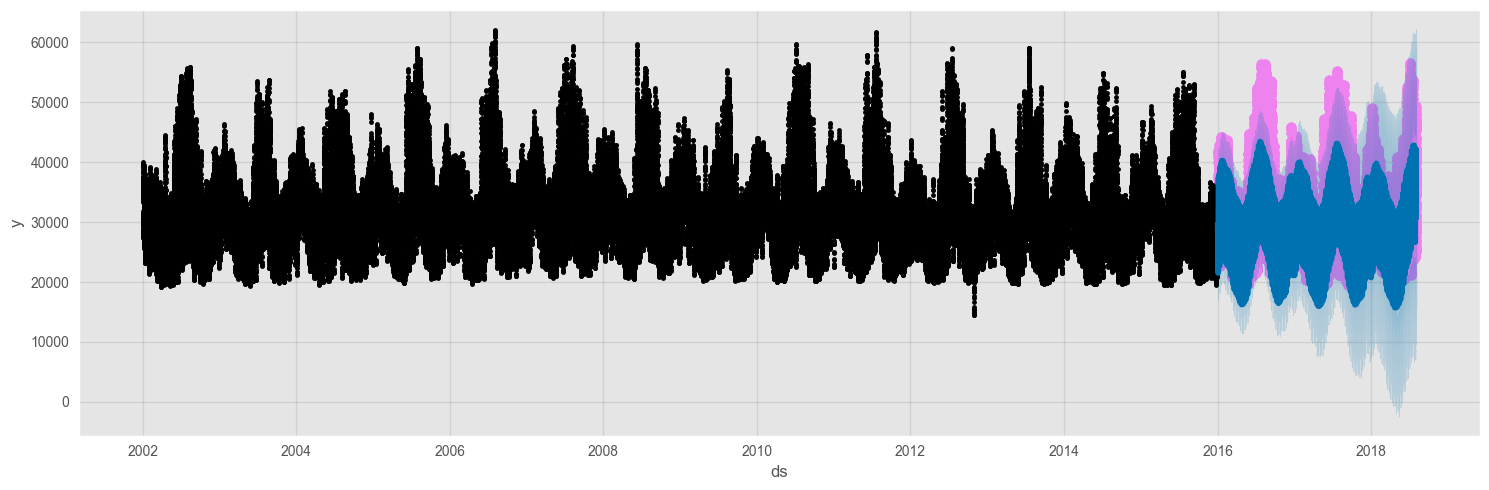

In [64]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['PJME_MW'], color='violet')
fig = model.plot(prophet_forecast, ax=ax)

Plot Components

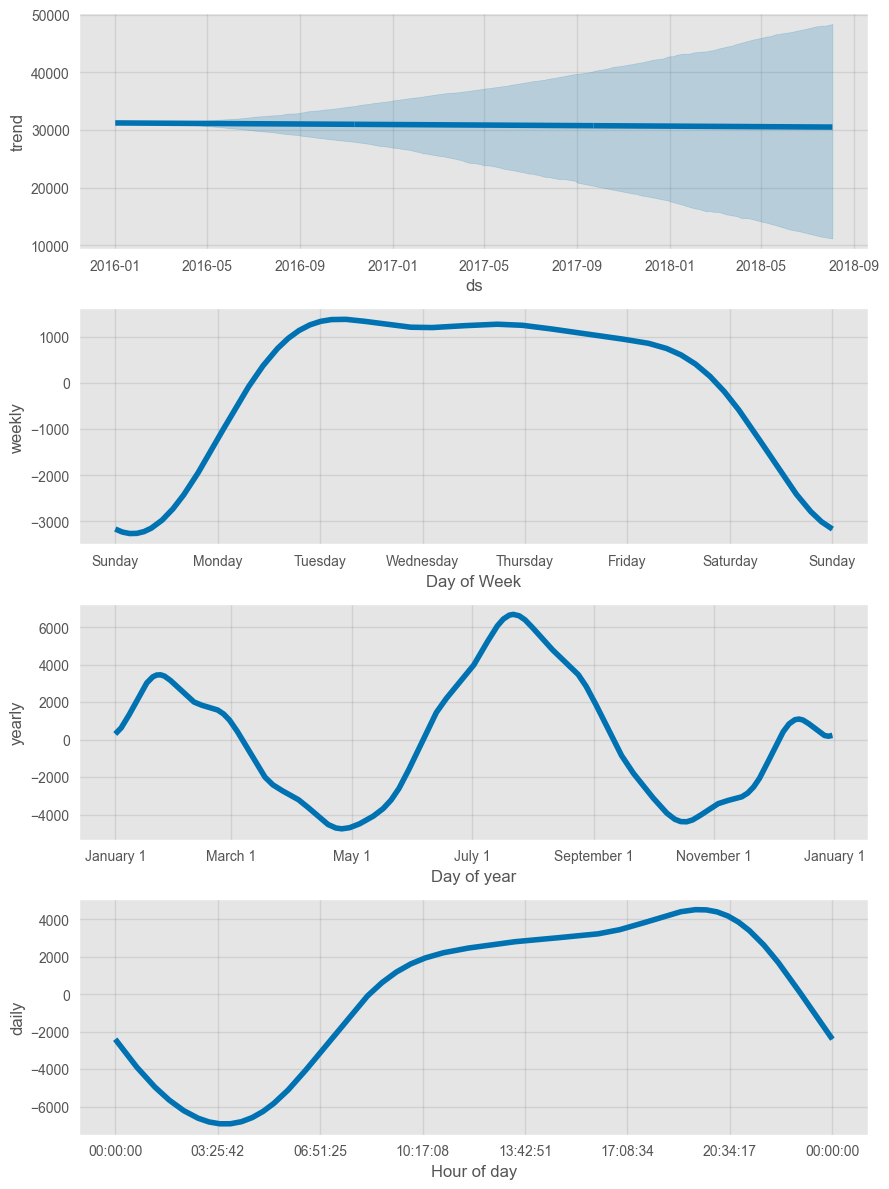

In [65]:
fig = model.plot_components(prophet_forecast)
plt.show()

Evaluate the model

In [67]:
# RMSE
np.sqrt(mean_squared_error(y_true=df_test['PJME_MW'],
                   y_pred=prophet_forecast['yhat']))

#MAPE
#mape(y_true=df_test['PJME_MW'],
#                   y_pred=prophet_forecast['yhat'])


6307.621116334434

ARIMA

In [38]:
df_arima = pd.read_csv("PJME_hourly.csv")
df_arima.Datetime = pd.DatetimeIndex(df_arima.Datetime)
df_arima = df_arima.reset_index(drop=True)
df_arima.index = pd.PeriodIndex(df_arima.Datetime, freq='H')

df_arima = df_arima.drop(df_arima.columns[0], axis=1)

train_arima = df_arima.loc[df_arima.index < split_point].copy()
test_arima= df_arima.loc[df_arima.index >= split_point].copy()

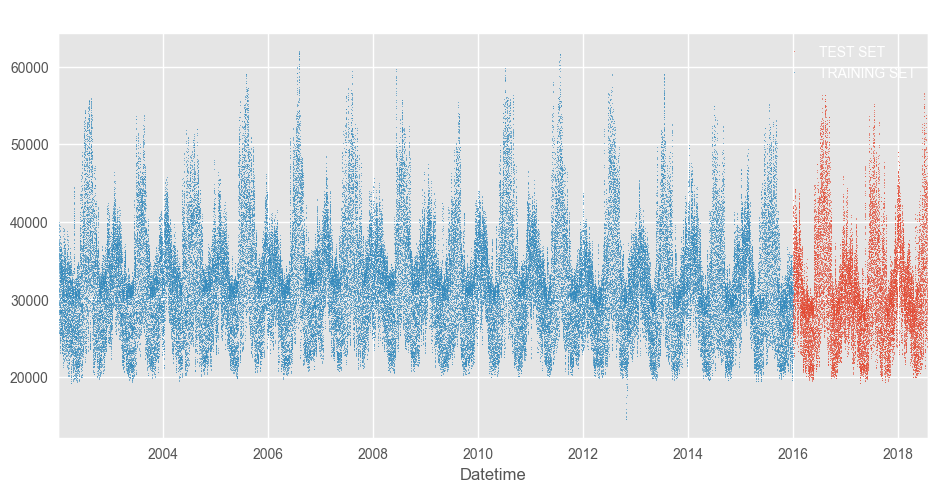

In [41]:
#model_arima= auto_arima(train_arima)
test_arima \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(train_arima.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Energy Consumption (MW)', style='.', ms=1)
plt.show()

In [43]:
model_arima = ARIMA(train_arima, order=(8,0,2))
model_arima_fit = model_arima.fit()
model_arima_fit.summary()

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJME_MW   No. Observations:               122686
Model:                 ARIMA(8, 0, 2)   Log Likelihood            -1027403.639
Date:                Mon, 01 May 2023   AIC                        2054831.277
Time:                        12:05:32   BIC                        2054947.886
Sample:                             0   HQIC                       2054866.343
                             - 122686                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.225e+04     89.400    360.715      0.000    3.21e+04    3.24e+04
ar.L1          1.1671      0.062     18.674      0.000       1.045       1.290
ar.L2          0.3528      0.128      2.747      0.006       0.101       0.605
ar.L3         -0.7222      0.096     -7.534      0.000      -0.910      -0.534
ar.L4          0.1778      0.028      6.314      0.000       0.123       0.233
ar.L5         -0.0331      0.006     -5.619      0.000      -0.045      -0.022
ar.L6         -0.0802      0.007    -11.455      0.000      -0.094      -0.066
ar.L7          0.0115      0.005      2.130      0.033       0.001       0.022
ar.L8          0.0749      0.005     14.815      0.000       0.065       0.085
ma.L1          0.4946      0.063      7.906      0.000       0.372       0.617
ma.L2         -0.2202      0.041     -5.434      0.000      -0.300      -0.141
sigma2      1.099e+06   2129.529    516.051      0.000    1.09e+06     1.1e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):            548214.77
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
arima_forecast = model_arima_fit.predict(start=len(train_arima), end=len(df_arima)-1, dynamic=False)
arima_forecast.head()

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


122686    28228.681203
122687    27404.629001
122688    27000.165445
122689    27011.824418
122690    27384.499806
Name: predicted_mean, dtype: float64

In [45]:
arima_forecast = pd.DataFrame(arima_forecast)


In [48]:
# RMSE
np.sqrt(mean_squared_error(y_true=test_arima['PJME_MW'],
                   y_pred=arima_forecast['predicted_mean']))

#MAPE
mape(y_true=test_arima['PJME_MW'],
                   y_pred=arima_forecast['predicted_mean'])

17.47525425248259